In [ ]:
!pip install -r requriments.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.

### **Import Libraries:**

In [ ]:
import os
import json
import pandas as pd
import tensorflow as tf
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense, Concatenate, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam, SGD
from keras import regularizers

nltk.download('punkt')
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load Data:**

#### Load json files:

In [ ]:
dir_path_train_data = "/content/drive/MyDrive/NLP Data" 
dir_path_test_data = "/content/drive/MyDrive/NLP Test" 

train_data_dict = {}
test_data_dict = {}


for folder_name in os.listdir(dir_path_train_data):
    folder_path = os.path.join(dir_path_train_data, folder_name)
    if os.path.isdir(folder_path):
      for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
          file_path = os.path.join(folder_path, filename)
          with open(file_path) as f:
            data = json.load(f)
            title = data['title']
            text = data['text']
            train_data_dict[filename[:-5]] = {'title': title, 'text': text}

for folder_name in os.listdir(dir_path_test_data):
    folder_path = os.path.join(dir_path_test_data, folder_name)
    if os.path.isdir(folder_path):
      for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
          file_path = os.path.join(folder_path, filename)
          with open(file_path) as f:
            data = json.load(f)
            title = data['title']
            text = data['text']
            test_data_dict[filename[:-5]] = {'title': title, 'text': text}

print('No of articles in Train data: ', len(train_data_dict))
print('No of articles in Test data: ', len(test_data_dict))

No of articles in Train data:  9401
No of articles in Test data:  9150


#### Load CSV file:

In [ ]:
train_csv = pd.read_csv('/content/train.csv')
test_csv = pd.read_csv('/content/test.csv')
train_csv.head()

,url1_lang,url2_lang,pair_id,link1,link2,ia_link1,ia_link2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,en,en,1484084337_1484110209,https://www.washingtonpost.com/local/virginia-...,https://www.washingtonpost.com/world/the_ameri...,https://web.archive.org/web/www.washingtonpost...,https://web.archive.org/web/www.washingtonpost...,4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,en,en,1484396422_1483924666,https://www.stlucianewsonline.com/guyana-three...,https://www.thestar.com/news/world/europe/2020...,https://web.archive.org/web/www.stlucianewsonl...,https://web.archive.org/web/www.thestar.com/ne...,4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,en,en,1484698254_1483758694,https://www.teaparty.org/trump-brings-in-2020-...,https://www.timesofisrael.com/trump-says-he-do...,https://web.archive.org/web/www.teaparty.org/t...,https://web.archive.org/web/www.timesofisrael....,1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,en,en,1576314516_1576455088,https://gadgets.ndtv.com/apps/news/zomato-uber...,https://gadgets.ndtv.com/internet/news/indian-...,https://web.archive.org/web/gadgets.ndtv.com/a...,https://web.archive.org/web/gadgets.ndtv.com/i...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,en,en,1484036253_1483894099,https://news.yahoo.com/india-approves-third-mo...,https://www.channelnewsasia.com/news/asia/indi...,https://web.archive.org/web/news.yahoo.com/ind...,https://web.archive.org/web/www.channelnewsasi...,1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000


In [ ]:
test_csv.head()

,url1_lang,url2_lang,pair_id,link1,link2,ia_link1,ia_link2,GEO,ENT,TIME,NAR,Overall,STYLE,TONE
0,en,en,1484189203_1484121193,https://wsvn.com/news/local/broward/police-2-m...,https://wsvn.com/news/local/no-swim-advisory-l...,https://web.archive.org/web/https://wsvn.com/n...,https://web.archive.org/web/https://wsvn.com/n...,1.5,4.0,2.0,4.0,3.5,1.0,1.500000
1,en,en,1484011097_1484011106,https://www.zdnet.com/article/autoclerk-databa...,https://securityboulevard.com/2019/10/best-wes...,https://web.archive.org/web/https://www.zdnet....,https://web.archive.org/web/https://securitybo...,1.0,2.0,1.0,1.0,1.0,3.5,2.500000
2,en,en,1484039488_1484261803,https://www.presstelegram.com/2019/12/31/ducks...,https://boingboing.net/2020/01/01/woody-guthri...,https://web.archive.org/web/https://www.presst...,https://web.archive.org/web/https://boingboing...,5.0,4.0,3.0,4.0,4.0,4.0,3.666667
3,en,en,1484332324_1484796748,https://www.financialexpress.com/india-news/we...,https://www.news18.com/news/india/not-the-firs...,https://web.archive.org/web/https://www.financ...,https://web.archive.org/web/https://www.news18...,1.0,1.5,1.0,1.5,1.5,1.5,2.000000
4,en,en,1484012256_1484419682,https://www.birminghammail.co.uk/whats-on/musi...,http://m.fightbacknews.org/2020/1/1/top-20-fil...,https://web.archive.org/web/https://www.birmin...,https://web.archive.org/web/http://m.fightback...,4.0,4.0,1.0,2.5,4.0,2.5,2.500000


#### Create dataframes for training and testing:

In [ ]:
def create_dataframe(article_data, csv_data):
  dataframe = pd.DataFrame()
  dataframe[["id_1", "id_2"]] = csv_data["pair_id"].str.split("_", expand = True)
  dataframe['lang_1'] = csv_data['url1_lang']
  dataframe['lang_2'] = csv_data['url2_lang']

  title1 =[]
  title2 =[]
  text1 = []
  text2 = []

  for i in range(len(dataframe)):
    try:
      title1.append(article_data[dataframe['id_1'][i]]['title'])
    except:
      title1.append(None)
    try:
      title2.append(article_data[dataframe['id_2'][i]]['title'])
    except:
      title2.append(None)
    try:
      text1.append(article_data[dataframe['id_1'][i]]['text'])
    except:
      text1.append(None)
    try:
      text2.append(article_data[dataframe['id_2'][i]]['text'])
    except:
      text2.append(None)
    
  dataframe['title_1'] = title1
  dataframe['title_2'] = title2
  dataframe['text_1'] = text1
  dataframe['text_2'] = text2
  dataframe['overall'] = csv_data['Overall']

  return dataframe

In [ ]:
train_data = create_dataframe(train_data_dict, train_csv)
test_data = create_dataframe(test_data_dict, test_csv)

In [ ]:
train_data.head()

,id_1,id_2,lang_1,lang_2,title_1,title_2,text_1,text_2,overall
0,1484084337,1484110209,en,en,Virginia man arrested in fatal DUI crash in We...,Haiti’s leader marks independence day amid sec...,"MARTINSBURG, W.Va. — A suspected drunken drive...","PORT-AU-PRINCE, Haiti — Haitian President Jove...",4.000000
1,1484396422,1483924666,en,en,Guyana: Three injured after car crashes into u...,Fire kills more than 30 animals at zoo in west...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,BERLIN - A fire at a zoo in western Germany in...,3.666667
2,1484698254,1483758694,en,en,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,"Trump says he does not expect war with Iran, ‘...",(Breitbart) – President Donald Trump welcomed ...,"PALM BEACH, United States — US President Donal...",2.333333
3,1576314516,1576455088,en,en,Zomato Buys Uber's Food Delivery Business in I...,Indian Online Food Delivery Market to Hit $8 B...,Uber has sold its online food-ordering busines...,Rapid digitisation and growth in both online b...,2.000000
4,1484036253,1483894099,en,en,"India approves third moon mission, months afte...",India targets new moon mission in 2020,BENGALURU (Reuters) - India has approved its t...,BANGALORE: India plans to make a fresh attempt...,1.250000


In [ ]:
test_data.head()

,id_1,id_2,lang_1,lang_2,title_1,title_2,text_1,text_2,overall
0,1484189203,1484121193,en,en,Police: 2 men stole tools from Lowe’s in Davie,No-swim advisory lifted for Deerfield Beach Pier,"DAVIE, FLA. (WSVN) - Police need help catching...","DEERFIELD BEACH, FLA. (WSVN) - A no-swim advis...",3.5
1,1484011097,1484011106,en,en,"Open database leaked 179GB in customer, US gov...",Best Western’s Massive Data Leak: 179GB Amazon...,Open database leaks travel logs of US governme...,The latest huge unsecured cloud storage find i...,1.0
2,1484039488,1484261803,en,en,Ducks are own worst enemies in sloppy loss in ...,Woody Guthrie's 1943 New Year's Resolutions ar...,"Ducks defenseman Erik Gudbranson, left, knocks...","I'd seen this before, but I was reminded of it...",4.0
3,1484332324,1484796748,en,en,Another Bengal vs Centre tussle? Govt rejects ...,'Congress Rejected 7 Times': BJP's Reminder as...,West Bengal Republic Day tableau: Twenty-two p...,Mumbai: The NCP and Shiv Sena on Thursday targ...,1.5
4,1484012256,1484419682,en,en,Bars and clubs you loved and lost in the past ...,Top 20 films of the 2010s,"Something went wrong, please try again later.\...",Free State of Jones comes in as number one\n\n...,4.0


### **Data Pre-processing:**

#### Check for Null entries:

In [ ]:
def remove_null(dataframe):
  print(dataframe.isnull().sum())
  print('Initial dataset size: ',dataframe.shape)
  df_clean = dataframe.dropna()
  print('After dropping Null data: ',df_clean.shape, '\n\n')

  return df_clean

In [ ]:
# For train set
df_train = remove_null(train_data) 
df_train.reset_index(inplace = True)

id_1        0
id_2        0
lang_1      0
lang_2      0
title_1    59
title_2    33
text_1     59
text_2     33
overall     0
dtype: int64
Initial dataset size:  (4964, 9)
After dropping Null data:  (4877, 9) 




In [ ]:
print('Summarize the pairs for training:')
table = pd.crosstab(df_train['lang_1'], df_train['lang_2'])
table

Summarize the pairs for training:


lang_2,ar,de,en,es,fr,pl,tr
lang_1,,,,,,,
ar,273,0,0,0,0,0,0
de,0,852,573,0,0,0,0
en,0,0,1752,0,0,0,0
es,0,0,0,560,0,0,0
fr,0,0,0,0,71,0,0
pl,0,0,0,0,0,337,0
tr,0,0,0,0,0,0,459


#### Clean data:

In [ ]:
def preprocess_data(text):
  
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  # Remove non-alphanumeric characters and non-whitespace characters
  text = re.sub(r'[^\w\s]', '', text)
  # Remove digits
  text = re.sub('[\d]+', '', text)
  tokens = word_tokenize(text)
  # Convert to lowercase
  tokens = [token.lower() for token in tokens]
  tokens = [token.strip() for token in tokens]
  text = ' '.join(tokens)
  
  return text

In [ ]:
for i in range(len(df_train)):
  df_train['title_1'][i] = preprocess_data(df_train['title_1'][i] + df_train['text_1'][i])
  df_train['title_2'][i] = preprocess_data(df_train['title_2'][i] + df_train['text_2'][i])

df_train = df_train.drop(columns=["text_1"])
df_train = df_train.drop(columns=["text_2"])
df_train = df_train.rename(columns={"title_1": "article_1"})
df_train = df_train.rename(columns={"title_2": "article_2"})

df_train.head()

<ipython-input-22-c667bd203aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['title_1'][i] = preprocess_data(df_train['title_1'][i] + df_train['text_1'][i])
<ipython-input-22-c667bd203aa8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['title_2'][i] = preprocess_data(df_train['title_2'][i] + df_train['text_2'][i])


,index,id_1,id_2,lang_1,lang_2,article_1,article_2,overall
0,0,1484084337,1484110209,en,en,virginia man arrested in fatal dui crash in we...,haitis leader marks independence day amid secu...,4.000000
1,1,1484396422,1483924666,en,en,guyana three injured after car crashes into ut...,fire kills more than animals at zoo in western...,3.666667
2,2,1484698254,1483758694,en,en,trump brings in at maralago were going to have...,trump says he does not expect war with iran li...,2.333333
3,3,1576314516,1576455088,en,en,zomato buys ubers food delivery business in in...,indian online food delivery market to hit bill...,2.000000
4,4,1484036253,1483894099,en,en,india approves third moon mission months after...,india targets new moon mission in bangalore in...,1.250000


#### Normalize Output Score:

In [ ]:
scaler = MinMaxScaler()

# Overall score for train data:
y_train = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_train['overall'])), columns=['overall'])

# Save data for future use
pd.DataFrame(y_train).to_csv('y_train', index=False)

#### Graph function:

In [ ]:
def plot_graphs(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

  # plot data on the first subplot
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend(['Train', 'Validation'], loc='upper right')

  # plot data on the second subplot
  ax2.plot(history.history['mean_absolute_error'])
  ax2.plot(history.history['val_mean_absolute_error'])
  ax2.set_title('Model MAE')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('MAE')
  ax2.legend(['Train', 'Validation'], loc='upper right')

  # display the plot
  plt.show()

### **Universal Sentence Encoder:**

In [ ]:
def encode_data(model, data):
  encoded_data = model.encode(data)

  return encoded_data

In [ ]:
embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# Encode the articles from training dataset
x1_train = encode_data(embedding_model, df_train['article_1'])
x2_train = encode_data(embedding_model, df_train['article_2'])

# Save data for future use
pd.DataFrame(x1_train).to_csv('x1_train', index=False)
pd.DataFrame(x2_train).to_csv('x2_train', index=False)



In [ ]:
# Load data from saved files
# x1_train = pd.read_csv('x1_train', encoding='utf-8')
# x2_train = pd.read_csv('x2_train', encoding='utf-8')
# y_train = pd.read_csv('y_train', encoding='utf-8')



### **Models:**

In [ ]:
model_reg1 = Sequential([
    Concatenate(),
    Dense(512, activation="relu"),
    Dense(512, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_reg1.compile(optimizer=optimizer, loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history1 = model_reg1.fit([x1_train, x2_train], y_train, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40


118/122 [============================>.] - ETA: 0s - loss: 0.2990 - mean_absolute_error: 0.2990

122/122 [==============================] - 5s 7ms/step - loss: 0.2994 - mean_absolute_error: 0.2994 - val_loss: 0.3552 - val_mean_absolute_error: 0.3552
Epoch 2/40
122/122 [==============================] - 1s 5ms/step - loss: 0.2381 - mean_absolute_error: 0.2381 - val_loss: 0.2898 - val_mean_absolute_error: 0.2898
Epoch 3/40
122/122 [==============================] - 1s 5ms/step - loss: 0.1831 - mean_absolute_error: 0.1831 - val_loss: 0.2788 - val_mean_absolute_error: 0.2788
Epoch 4/40
122/122 [==============================] - 1s 5ms/step - loss: 0.1502 - mean_absolute_error: 0.1502 - val_loss: 0.2818 - val_mean_absolute_error: 0.2818
Epoch 5/40
122/122 [==============================] - 1s 5ms/step - loss: 0.1308 - mean_absolute_error: 0.1308 - val_loss: 0.2696 - val_mean_absolute_error: 0.2696
Epoch 6/40
122/122 [==============================] - 1s 5ms/step - loss: 0.1142 - mean_absolute_error: 0.1142 - val_loss: 0.2976 - val_mean_absolute_error: 0.2976
Epoch 7/40
122/122 [=======

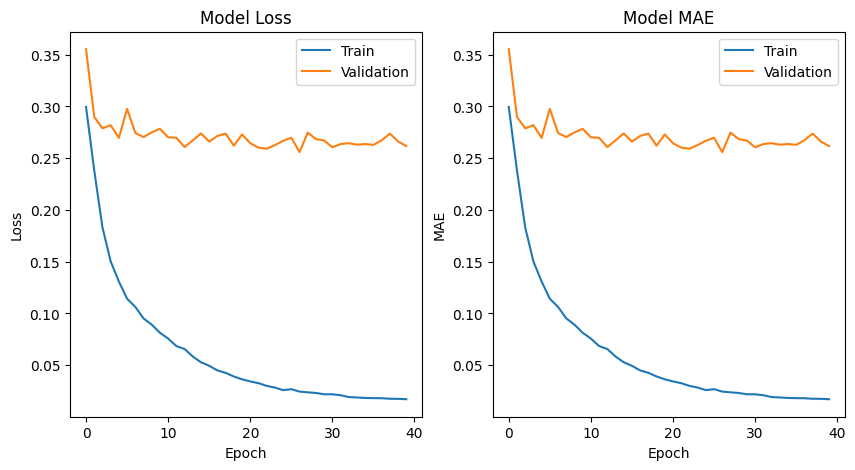

In [ ]:
plot_graphs(history1)

In [ ]:
model_reg2 = Sequential([
    Concatenate(),
    Dense(64, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_reg2.compile(optimizer=optimizer, loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history2 = model_reg2.fit([x1_train, x2_train], y_train, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40


113/122 [==========================>...] - ETA: 0s - loss: 0.3184 - mean_absolute_error: 0.3184

122/122 [==============================] - 3s 8ms/step - loss: 0.3163 - mean_absolute_error: 0.3163 - val_loss: 0.3382 - val_mean_absolute_error: 0.3382
Epoch 2/40
122/122 [==============================] - 1s 7ms/step - loss: 0.2754 - mean_absolute_error: 0.2754 - val_loss: 0.3438 - val_mean_absolute_error: 0.3438
Epoch 3/40
122/122 [==============================] - 1s 6ms/step - loss: 0.2541 - mean_absolute_error: 0.2541 - val_loss: 0.3243 - val_mean_absolute_error: 0.3243
Epoch 4/40
122/122 [==============================] - 1s 6ms/step - loss: 0.2323 - mean_absolute_error: 0.2323 - val_loss: 0.3248 - val_mean_absolute_error: 0.3248
Epoch 5/40
122/122 [==============================] - 1s 6ms/step - loss: 0.2086 - mean_absolute_error: 0.2086 - val_loss: 0.3338 - val_mean_absolute_error: 0.3338
Epoch 6/40
122/122 [==============================] - 1s 7ms/step - loss: 0.1855 - mean_absolute_error: 0.1855 - val_loss: 0.3128 - val_mean_absolute_error: 0.3128
Epoch 7/40
122/122 [=======

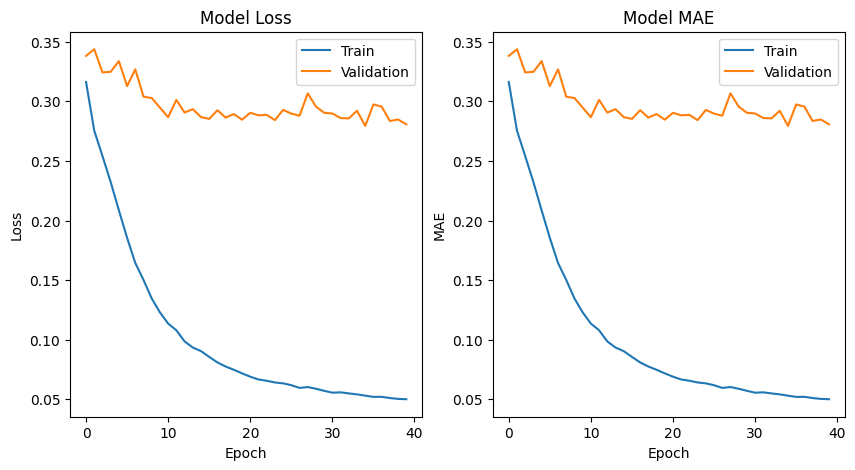

In [ ]:
plot_graphs(history2)

In [ ]:

model_reg1_regularised = Sequential([
    Concatenate(),
    BatchNormalization(),
    Dense(512, activation="relu", kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation="relu", kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(16, activation="relu", kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation="sigmoid", kernel_regularizer = l2(0.001))
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_reg1_regularised.compile(optimizer=optimizer, loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history_regularised1 = model_reg1_regularised.fit([x1_train, x2_train], y_train, epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60


118/122 [============================>.] - ETA: 0s - loss: 1.6356 - mean_absolute_error: 0.3562

122/122 [==============================] - 7s 15ms/step - loss: 1.6329 - mean_absolute_error: 0.3548 - val_loss: 1.5683 - val_mean_absolute_error: 0.3299
Epoch 2/60
122/122 [==============================] - 2s 13ms/step - loss: 1.4876 - mean_absolute_error: 0.2951 - val_loss: 1.4514 - val_mean_absolute_error: 0.3072
Epoch 3/60
122/122 [==============================] - 1s 8ms/step - loss: 1.3640 - mean_absolute_error: 0.2691 - val_loss: 1.3573 - val_mean_absolute_error: 0.3121
Epoch 4/60
122/122 [==============================] - 1s 8ms/step - loss: 1.2461 - mean_absolute_error: 0.2492 - val_loss: 1.2525 - val_mean_absolute_error: 0.3046
Epoch 5/60
122/122 [==============================] - 1s 8ms/step - loss: 1.1359 - mean_absolute_error: 0.2346 - val_loss: 1.1880 - val_mean_absolute_error: 0.3326
Epoch 6/60
122/122 [==============================] - 1s 9ms/step - loss: 1.0307 - mean_absolute_error: 0.2191 - val_loss: 1.0934 - val_mean_absolute_error: 0.3243
Epoch 7/60
122/122 [=====

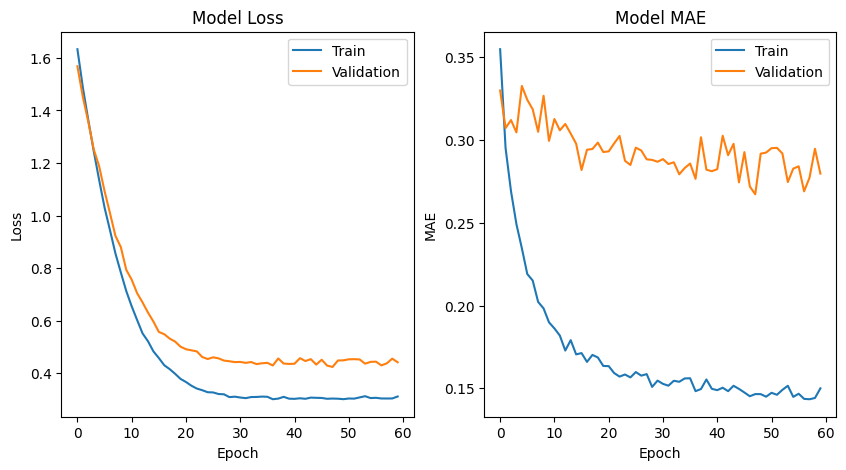

In [ ]:
plot_graphs(history_regularised1)

In [ ]:
model_reg2_regularised = Sequential([
    Concatenate(),
    Dense(64, activation="relu" ,kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(16, activation="relu" ,kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_reg2_regularised.compile(optimizer=optimizer, loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history_regularised2 = model_reg2_regularised.fit([x1_train, x2_train], y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


121/122 [============================>.] - ETA: 0s - loss: 0.5260 - mean_absolute_error: 0.3786

122/122 [==============================] - 4s 12ms/step - loss: 0.5252 - mean_absolute_error: 0.3779 - val_loss: 0.4767 - val_mean_absolute_error: 0.3300
Epoch 2/100
122/122 [==============================] - 2s 13ms/step - loss: 0.4977 - mean_absolute_error: 0.3516 - val_loss: 0.4731 - val_mean_absolute_error: 0.3277
Epoch 3/100
122/122 [==============================] - 1s 9ms/step - loss: 0.4764 - mean_absolute_error: 0.3316 - val_loss: 0.4749 - val_mean_absolute_error: 0.3308
Epoch 4/100
122/122 [==============================] - 1s 9ms/step - loss: 0.4673 - mean_absolute_error: 0.3238 - val_loss: 0.4877 - val_mean_absolute_error: 0.3448
Epoch 5/100
122/122 [==============================] - 1s 10ms/step - loss: 0.4585 - mean_absolute_error: 0.3162 - val_loss: 0.5043 - val_mean_absolute_error: 0.3627
Epoch 6/100
122/122 [==============================] - 1s 10ms/step - loss: 0.4418 - mean_absolute_error: 0.3009 - val_loss: 0.5062 - val_mean_absolute_error: 0.3660
Epoch 7/100
122/12

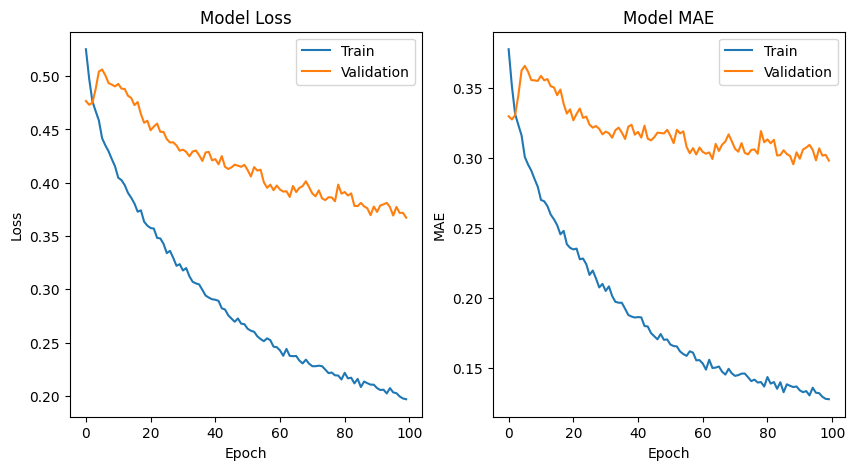

In [ ]:
plot_graphs(history_regularised2)


In [ ]:
with open('network.txt', 'w') as f:
  model_reg2_regularised.summary(print_fn=lambda x: f.write(x + '\n'))


### **Evaluation:**

#### Prepare test data:

In [ ]:
# Null check for test set
df_test = remove_null(test_data)
df_test.reset_index(inplace = True)

id_1         0
id_2         0
lang_1       0
lang_2       0
title_1    291
title_2    279
text_1     291
text_2     279
overall      0
dtype: int64
Initial dataset size:  (4902, 9)
After dropping Null data:  (4434, 9) 




In [ ]:
print('Summarize the pairs for testing:')
table = pd.crosstab(df_test['lang_1'], df_train['lang_2'])
table

Summarize the pairs for testing:


lang_2,ar,de,en,es,fr,pl,tr
lang_1,,,,,,,
ar,0,194,40,53,0,0,0
de,114,65,307,197,0,10,34
en,0,63,101,42,0,15,12
es,113,136,390,81,20,37,119
fr,0,0,1,0,0,110,11
it,0,0,375,0,0,6,3
pl,15,67,43,0,36,0,116
ru,0,0,277,0,0,0,0
tr,0,144,128,0,0,0,0


In [ ]:
# Preprocess test data

for i in range(len(df_test)):
  df_test['title_1'][i] = preprocess_data(df_test['title_1'][i] + df_test['text_1'][i])
  df_test['title_2'][i] = preprocess_data(df_test['title_2'][i] + df_test['text_2'][i])

df_test = df_test.drop(columns=["text_1"])
df_test = df_test.drop(columns=["text_2"])
df_test = df_test.rename(columns={"title_1": "article_1"})
df_test = df_test.rename(columns={"title_2": "article_2"})

df_test.head()

<ipython-input-23-2cc52ed994cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['title_1'][i] = preprocess_data(df_test['title_1'][i] + df_test['text_1'][i])
<ipython-input-23-2cc52ed994cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['title_2'][i] = preprocess_data(df_test['title_2'][i] + df_test['text_2'][i])


,index,id_1,id_2,lang_1,lang_2,article_1,article_2,overall
0,0,1484189203,1484121193,en,en,police men stole tools from lowes in daviedavi...,noswim advisory lifted for deerfield beach pie...,3.5
1,1,1484011097,1484011106,en,en,open database leaked gb in customer us governm...,best westerns massive data leak gb amazon data...,1.0
2,2,1484039488,1484261803,en,en,ducks are own worst enemies in sloppy loss in ...,woody guthries new years resolutions are a pow...,4.0
3,3,1484332324,1484796748,en,en,another bengal vs centre tussle govt rejects s...,congress rejected times bjps reminder as row o...,1.5
4,4,1484012256,1484419682,en,en,bars and clubs you loved and lost in the past ...,top films of the sfree state of jones comes in...,4.0


In [ ]:
# Normalize Overall score for test data:
y_test = pd.DataFrame(scaler.transform(pd.DataFrame(df_test['overall'])), columns=['overall'])

# Save data for future use
pd.DataFrame(y_test).to_csv('y_test', index=False)

In [ ]:
# Encode the articles from testing dataset
x1_test = encode_data(embedding_model, df_test['article_1'])
x2_test = encode_data(embedding_model, df_test['article_2'])

# Save data for future use
pd.DataFrame(x1_test).to_csv('x1_test', index=False)
pd.DataFrame(x2_test).to_csv('x2_test', index=False)

In [ ]:
# Load data from saved files
# x1_test = pd.read_csv('x1_test', encoding='utf-8')
# x2_test = pd.read_csv('x2_test', encoding='utf-8')
# y_test = pd.read_csv('y_test', encoding='utf-8')

#### Test Models:

In [ ]:

def predict_func(model, x):
  y_pred = model.predict(x)

  return y_pred

def mae_calculate(y_true, y_pred):
  mae = np.mean(np.abs(y_pred - y_true))
  print('\n\nMAE value for test data: ', mae[0], '\n\n')

In [ ]:
test_output = predict_func(model_reg2_regularised, [x1_test, x2_test])
mae_calculate(y_test, test_output)

139/139 [==============================] - 1s 3ms/step


MAE value for test data:  0.3057687847196667 




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
test_output = predict_func(model_reg2, [x1_test, x2_test])
mae_calculate(y_test, test_output)

139/139 [==============================] - 0s 2ms/step


MAE value for test data:  0.3000845917199637 




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
